In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import product_reviews_2, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import nltk.corpus
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
import spacy
from sklearn.pipeline import make_pipeline

In [2]:
# Load the data
medium_art_df = pd.read_csv('C:/Users/keith/Desktop/Thinkful/Medium_AggregatedData.csv')
pd.set_option('display.max_columns', 50)

In [3]:
medium_art_df.shape

(279577, 50)

In [4]:
medium_art_df.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,It,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robotics,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [5]:
len(medium_art_df.author.unique())

31021

# Classifying Authors of Medium.com Articles
In this project we will attempt to classify authors based on their writings of Medium.com articles using supervised and unsupervised methods. 


## The data
 
The articles will all be based on artificial intelligence, machine learning, or data science. The data is a set of 279577 articles written by 31021 unique authors. The data contains features such as number of claps(Medium.com's rating), the link to the article, the title, and the article itself. For our purpose we will only focus on a portion of the data, the author column and the article column.


The data is also a mixture of articles in several diffierent languages. We will limit the data set to only article written in English.

In [6]:
# filter out only articles in English
medium_art_df = medium_art_df[medium_art_df.language=='en']
medium_art_df.index = range(len(medium_art_df))

In [7]:
medium_art_df.wordCount.describe()

count    257655.000000
mean        955.194590
std         888.268726
min           0.000000
25%         444.000000
50%         750.000000
75%        1197.000000
max       24964.000000
Name: wordCount, dtype: float64

The articles also range from 1197 words to over 24000 words. Here we will drop articles that are less than the median word count in oder to have a large enough corpus for analysis.


In [8]:
# select rows that are less than the median 
to_drop = np.where(medium_art_df.wordCount<medium_art_df.wordCount.median())[0]
medium_art_df.drop(to_drop,0,inplace=True)
medium_art_df.index = range(len(medium_art_df))

Some of the texts were duplicates so we'll drop those next

In [9]:
# duplicated texts
medium_art_df.text.duplicated().sum()

97227

In [10]:
# dropping duplicates and keeping one copy
medium_art_df.text.drop_duplicates(keep='first',inplace=True)
medium_art_df.index = range(len(medium_art_df))

In [11]:
medium_art_df.tag_name.value_counts()

Artificial Intelligence     15614
Machine Learning            14346
Data Science                 8675
Deep Learning                3501
Technology                   3255
Python                       1669
Blockchain                   1610
Chatbots                     1340
Tech                         1330
Neural Networks              1316
Big Data                     1288
Startup                      1212
Data                         1021
Analytics                     828
Future                        751
Data Visualization            747
Bots                          736
Programming                   736
Towards Data Science          712
Robotics                      697
Data Analysis                 673
Cryptocurrency                672
Business                      594
Statistics                    582
Innovation                    576
Computer Vision               558
Marketing                     537
Education                     520
Automation                    517
Healthcare    

For this project we want to try to classify the authors of the articles. To make it more challenging to do this we will select authors from the same topic of text. We'll choose the "Artificial Intelligence" topic.

In [12]:
# limit dataset to only articles about artificial intelligence
medium_art_df = medium_art_df[medium_art_df.tag_name=='Artificial Intelligence']
medium_art_df.index = range(len(medium_art_df))

In [13]:
medium_art_df.author.value_counts()

Jae Duk Seo                           124
Derrick Harris                         82
Synced                                 82
Michael K. Spencer                     67
Carlos E. Perez                        66
Daily Wisdom                           62
Jesus Rodriguez                        58
World Economic Forum                   48
Conrad Gray                            45
Jonathan Hui                           44
Alibaba Cloud                          37
william smith                          37
Neuromation                            33
Sukant Khurana                         32
Julien Simon                           32
Future of Life                         31
MIT Technology Review                  30
Doc Huston                             30
Shashank Gupta                         26
Justin Lee                             24
#ODSC - The Data Science Community     23
MarTech Advisor                        22
Oleksii Kharkovyna                     22
elvis                             

Well choose the first 10 single authors texts. From those we'll choose 10 articles each for analysis. This will give us 100 articles to work with.

In [14]:
# choose indicies of 10 authors
author_index = np.where((medium_art_df.author== 'Jae Duk Seo')|                                              
                        (medium_art_df.author== 'Derrick Harris')|
                        (medium_art_df.author== 'Michael K. Spencer' )|                                            
                        (medium_art_df.author== 'Carlos E. Perez' )|
                        (medium_art_df.author== 'Jesus Rodriguez' )|
                        (medium_art_df.author== 'Conrad Gray' )|
                        (medium_art_df.author== 'Jonathan Hui' )|
                        (medium_art_df.author==  'william smith' )|
                        (medium_art_df.author== 'Sukant Khurana' )|
                        (medium_art_df.author== 'Julien Simon'))[0]
medium_art_df = medium_art_df.loc[author_index,:]                                              
medium_art_df.index = range(len(medium_art_df))

In [15]:
medium_art_df.author.value_counts()[:10]

Jae Duk Seo           124
Derrick Harris         82
Michael K. Spencer     67
Carlos E. Perez        66
Jesus Rodriguez        58
Conrad Gray            45
Jonathan Hui           44
william smith          37
Julien Simon           32
Sukant Khurana         32
Name: author, dtype: int64

In [16]:
authors = medium_art_df.author.value_counts()[:10].index

In [17]:
# create dataframe that holds 10 authors with 10 different articles each
selected = pd.DataFrame()
for author in authors:     
    articles = medium_art_df[medium_art_df.author==author][:10][['author','text','tag_name','title','totalClapCount','wordCount']]     
    selected = selected.append(articles)
medium_text_df = selected.reset_index().drop('index',1)    

In [18]:
medium_text_df.author.value_counts()

Derrick Harris        10
Conrad Gray           10
william smith         10
Michael K. Spencer    10
Jae Duk Seo           10
Sukant Khurana        10
Julien Simon          10
Jonathan Hui          10
Jesus Rodriguez       10
Carlos E. Perez       10
Name: author, dtype: int64

In [19]:
medium_text_df.shape

(100, 6)

In [20]:
# quick check for null values
medium_text_df.isna().sum()

author            0
text              0
tag_name          0
title             0
totalClapCount    0
wordCount         0
dtype: int64

In [21]:
medium_text_df.text.duplicated().sum()

0

### Text cleaning

In [22]:
# a little cleaning
def clean_txt(text): 
    
    text  = re.sub(r"\W", ' ', text) 
    text  = re.sub(r"http\S+", '', text) # some of the web addresses
    text = re.sub("[^a-zA-Z.' ]+", " ", text) #removes anything that isn't a letter
    text = re.sub('\[.*?\]', " ", text)# removes text and brackets if there are words or letters in brackets
    text = re.sub('\w*\d\w*', '', text)# removes breaks
    text  = re.sub(r'^[^ ]*', '', text) # removes single letters
    text = re.sub(r"[{}]".format(string.punctuation), " ", text) # removes puntuation
    text = " ".join(text.split()).strip().lower() #strips white space and joins the list back into a string
    
    return text;

In [23]:
medium_text_df.loc[:,'clean_text'] = medium_text_df.loc[:,'text'].apply(lambda x: clean_txt(x))

In [24]:
medium_text_df.head()

,author,text,tag_name,title,totalClapCount,wordCount,clean_text
0,Jae Duk Seo,Deeper Understanding of Batch Normalization wi...,Artificial Intelligence,Deeper Understanding of Batch Normalization wi...,126,2058,understanding of batch normalization with inte...
1,Jae Duk Seo,Shake-Shake regularization with Interactive Co...,Artificial Intelligence,Shake-Shake regularization with Interactive Co...,12,1267,shake regularization with interactive code man...
2,Jae Duk Seo,[ Google ] Continuously Differentiable Exponen...,Artificial Intelligence,[ Google ] Continuously Differentiable Exponen...,25,1077,google continuously differentiable exponential...
3,Jae Duk Seo,[ NIPS 2016 ] Direct Feedback Alignment Provid...,Artificial Intelligence,[ NIPS 2016 ] Direct Feedback Alignment Provid...,146,1934,nips direct feedback alignment provides learni...
4,Jae Duk Seo,"Trend, Seasonality, Moving Average, Auto Regre...",Artificial Intelligence,"Trend, Seasonality, Moving Average, Auto Regre...",89,1256,seasonality moving average auto regressive mod...


In [25]:
X = medium_text_df 
Y = medium_text_df.author

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=0)


In [27]:
# import text in case stop words need to be added to stopword dictionary
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS 

# Feature Extraction 

### Features using TFIDF

In [28]:
# function to incorporate SpaCy into TfidfVectorizor
nlp = spacy.load('en') 
def tokenizer(text):
    text = nlp(text)
    lemmas = [token.lemma_ 
                for token in text   
                if not token.is_punct
                and not token.is_stop]      
    return lemmas; 

In [29]:
# create TFIDF object
vectorizer = TfidfVectorizer(
                            # ngram_range=(1,2),
                             max_df=0.3, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             sublinear_tf=True,
                             stop_words='english',
                             tokenizer=tokenizer,# get lemmas from SpaCy
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

 

#Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train.clean_text)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_test_tfidf = vectorizer.transform(X_test.clean_text)
  


Number of features: 3345


In [30]:
tfidf_matrix = pd.DataFrame(X_train_tfidf.toarray(),columns=vectorizer.get_feature_names(),index=X_train.author)

In [31]:
tfidf_matrix.head()

,-PRON-,aadhar,abbreviate,ability,abnormal,abs,absolute,absolutely,absorb,abstract,abstraction,abuse,ac,academia,academic,academy,accelerate,acceleration,acceptable,acceptance,accessible,accomplish,accord,accordingly,account,...,writer,writing,wrong,ww,x,xlarge,y,yahoo,yale,yellow,yes,yesterday,yield,yolo,yolov,york,yoshua,young,youtube,z,zach,zdnet,zero,zoo,zuckerberg
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jesus Rodriguez,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Jae Duk Seo,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.035451,...,0.0,0.039259,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.039259,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Sukant Khurana,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027869,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.025165,0.0,0.025165,...,0.0,0.000000,0.0,0.0,0.066482,0.0,0.064033,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.034106,0.000000,0.0,0.0,0.000000,0.000000
Julien Simon,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.108188,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.031418,0.0,0.0,0.0,0.0,0.000000,0.045337,0.00000,0.000000,0.000000,0.045337,0.0,0.0,0.076763,0.000000
william smith,0.0,0.0,0.043705,0.024114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.043705,0.0,0.0,0.03843,0.0,0.0,0.0,0.043669,0.0,0.025792,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.034955,0.000000,0.05479,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.065067


In [32]:
#group author columns
tfidf_matrix = tfidf_matrix.T.groupby(level=0,axis=1).sum() 
tfidf_matrix.head()

author,Carlos E. Perez,Conrad Gray,Derrick Harris,Jae Duk Seo,Jesus Rodriguez,Jonathan Hui,Julien Simon,Michael K. Spencer,Sukant Khurana,william smith
-PRON-,0.000000,0.000000,0.000000,0.000000,0.086014,0.053253,0.000000,0.000000,0.000000,0.000000
aadhar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121429,0.000000
abbreviate,0.000000,0.000000,0.056733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043705
ability,0.119292,0.079049,0.032184,0.031028,0.234768,0.000000,0.033588,0.173571,0.099887,0.109767
abnormal,0.000000,0.000000,0.033268,0.000000,0.000000,0.000000,0.000000,0.000000,0.052012,0.000000


Here we'll create word clouds for the top 100 words of each author

In [33]:
from wordcloud import WordCloud 
wc = WordCloud(background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

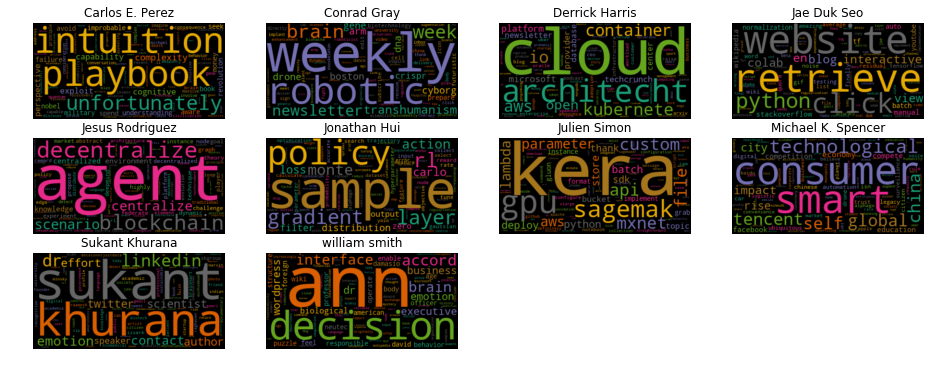

In [34]:
# create wordclouds for each author

plt.figure(figsize=(16, 6))
 
for index, author in enumerate(tfidf_matrix.columns):
    wc.generate(' '.join(tfidf_matrix[author].sort_values(ascending=False).index[:100]))
     
    plt.subplot(3,4, index+1,)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(author)
plt.show()

We can notice that the author's name appears in some of the word clouds. You can also somewhat tell the nature of the artificial intelligence article.

Next we'll make a stop word list and add additional stop words the the SpaCy stop word list. Some words that will be added are the names of the authors so that no information will be passed when we start training the supervised models.

In [35]:
from sklearn.feature_extraction import text 

#add author names to stop word list
author_names = ['Carlos', 'E', 'Perez', 'Conrad' ,'Gray', 'Derrick', 'Harris', 'Jae' ,'Duk' ,'Seo',
                           'Jesus Rodriguez', 'Jonathan', 'Hui', 'Julien', 'Simon', 'Michael', 'K', 'Spencer',
                           'sukant','khurana', 'william', 'smith'] 
my_stop_words = text.ENGLISH_STOP_WORDS.union(author_names)


for w in author_names:
    nlp.vocab[w].is_stop = True

Let's make some word clouds with the new stop words removed.

In [36]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=my_stop_words, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

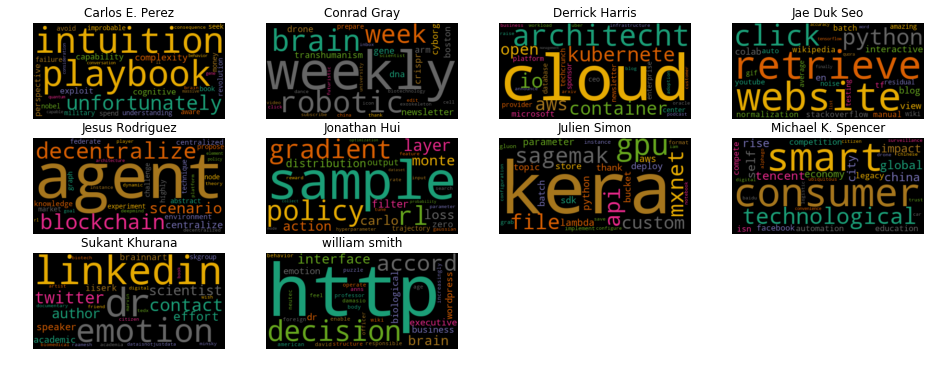

In [37]:
# create wordclouds for each author

plt.figure(figsize=(16, 6))
 
for index, author in enumerate(tfidf_matrix.columns):
    wc.generate(' '.join(tfidf_matrix[author].sort_values(ascending=False).index[:30]))
     
    plt.subplot(3,4, index+1,)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(author)
plt.show()

Next we'll create a new features with the new stop words removed

In [38]:
# create TFIDF object
vectorizer = TfidfVectorizer(tokenizer=tokenizer,# get lemmas from SpaCy
                             ngram_range=(1,2),
                             max_df=0.2, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             sublinear_tf=True,
                             stop_words='english',
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

 

#Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train.clean_text)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_test_tfidf = vectorizer.transform(X_test.clean_text)


Number of features: 6526


### Features from Latent Semantic Analysis

In [39]:
# set up LSA features
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(14,random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))


# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()


print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 30.585205174279523


### Bag of Words features


First we'll combine all the articles from each author in to a data frame.

In [40]:
author_corpus_df = pd.DataFrame(medium_text_df.groupby('author').clean_text.sum())

In [41]:
author_corpus_df

,clean_text
author,
Carlos E. Perez,meta model and meta meta model of deep learnin...
Conrad Gray,this week vladimir putin on ai the ethics of h...
Derrick Harris,by thomas kvistholt on unsplash google embrace...
Jae Duk Seo,understanding of batch normalization with inte...
Jesus Rodriguez,deep learning to understand your source code t...
Jonathan Hui,a deep learning network part you have build a ...
Julien Simon,a spam classifier pyspark mllib vs sagemaker x...
Michael K. Spencer,unemployment and ubi reuters murad seze while ...
Sukant Khurana,ethics in artificial intelligence by aadhar sh...


In [42]:
# fuction that tokens text and lemmatizes articles
def word_bag(text):
    text = nlp(text) # tokenize the data with Space
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

In [43]:
# create a new columns for the bag of words for each author
author_corpus_df['Words'] = author_corpus_df.clean_text.apply(lambda x: word_bag(x))

In [44]:
author_corpus_df

,clean_text,Words
author,,
Carlos E. Perez,meta model and meta meta model of deep learnin...,"[deep, learning, s, ai, meta, model, system, t..."
Conrad Gray,this week vladimir putin on ai the ethics of h...,"[ai, s, robot, human, robotic, like, intellige..."
Derrick Harris,by thomas kvistholt on unsplash google embrace...,"[s, ai, com, datum, cloud, t, google, company,..."
Jae Duk Seo,understanding of batch normalization with inte...,"[image, retrieve, com, time, network, website,..."
Jesus Rodriguez,deep learning to understand your source code t...,"[ai, model, agent, network, learning, learn, d..."
Jonathan Hui,a deep learning network part you have build a ...,"[model, policy, network, value, object, use, d..."
Julien Simon,a spam classifier pyspark mllib vs sagemaker x...,"[s, model, training, datum, let, set, learning..."
Michael K. Spencer,unemployment and ubi reuters murad seze while ...,"[s, amazon, ai, human, future, t, company, tec..."
Sukant Khurana,ethics in artificial intelligence by aadhar sh...,"[ai, s, human, research, seizure, intelligence..."


In [45]:
# set containing top 2000 words from each author
common_bag_of_words = set(author_corpus_df.Words.sum())

In [46]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_bag_of_words)
    #df['article'] = 
    df['text_source'] = sentences['author'].values
    df.loc[:, common_words] = 0
     
    # Process each row, counting the occurrence of words in each sentence.
    for i, article in enumerate(sentences['clean_text'].values):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in nlp(article)  
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In [47]:
Count_matrix = bow_features(medium_text_df, common_bag_of_words)

Processing row 0
Processing row 50


In [48]:
Count_matrix['clean_text'] = medium_text_df.clean_text

In [49]:
Count_matrix.text_source.value_counts()

Derrick Harris        10
Conrad Gray           10
william smith         10
Michael K. Spencer    10
Jae Duk Seo           10
Sukant Khurana        10
Julien Simon          10
Jonathan Hui          10
Jesus Rodriguez       10
Carlos E. Perez       10
Name: text_source, dtype: int64

In [50]:
Count_matrixT = Count_matrix.copy()
Count_matrixT.index = Count_matrix.text_source
Count_matrixT = Count_matrixT.drop(['text_source','clean_text'],1).T

In [51]:
#create term document matrix
Count_matrixT = Count_matrixT.groupby(level=0, axis=1).sum()
Count_matrixT.head()

text_source,Carlos E. Perez,Conrad Gray,Derrick Harris,Jae Duk Seo,Jesus Rodriguez,Jonathan Hui,Julien Simon,Michael K. Spencer,Sukant Khurana,william smith
shortcoming,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
incubation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
yoy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
regenerative,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gtx,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
# create and array of all of the non zero terms for each author in the matrixT
words = []
for c in Count_matrixT.columns:
    terms = Count_matrixT[c].sort_values().sort_values(ascending=False)     
    for i ,j in enumerate(terms):
         if j>0:
             words.append(Count_matrixT[c].sort_values().sort_values(ascending=False).index[i])
             

In [53]:
#get the most common words
Counter(words).most_common()[:10]

[('deep', 10),
 ('learning', 10),
 ('s', 10),
 ('ai', 10),
 ('model', 10),
 ('system', 10),
 ('t', 10),
 ('learn', 10),
 ('need', 10),
 ('like', 10)]

In [54]:
# variable to hold additional stop words. Words that appear in over 6 of the authors
addbow_stop_words = [word for word, count in Counter(words).most_common() if count > 6]

In [55]:
from sklearn.feature_extraction import text 

#add author names to stop word list
author_names = ['Carlos', 'E', 'Perez', 'Conrad' ,'Gray', 'Derrick', 'Harris', 'Jae' ,'Duk' ,'Seo',
                           'Jesus Rodriguez', 'Jonathan', 'Hui', 'Julien', 'Simon', 'Michael', 'K', 'Spencer',
                           'sukant','khurana', 'william', 'smith'] 
BOW_stop_words = text.ENGLISH_STOP_WORDS.union(author_names+addbow_stop_words)


for w in BOW_stop_words:
    nlp.vocab[w].is_stop = True

In [56]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=BOW_stop_words, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

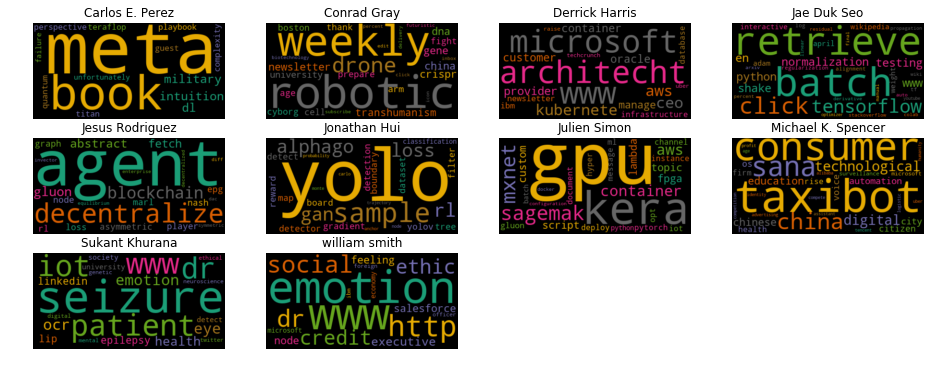

In [57]:
# create wordclouds for each author

plt.figure(figsize=(16, 6))
 
for index, author in enumerate(Count_matrixT.columns):
    wc.generate(' '.join(Count_matrixT[author].sort_values(ascending=False).index[:100]))
     
    plt.subplot(3,4, index+1,)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(author)
plt.show()

In [58]:
author_corpus_df['Words'] = author_corpus_df.clean_text.apply(lambda x: word_bag(x))

In [59]:
Count_matrix = bow_features(medium_text_df, common_bag_of_words)

Processing row 0
Processing row 50


In [60]:
Count_matrix['clean_text'] = medium_text_df.clean_text

In [61]:
# Split the Bag of Words data
Y = Count_matrix['text_source']
X = np.array(Count_matrix.drop(['clean_text','text_source'], 1))
X_train_bow, X_test_bow,y_train_bow,y_test_bow = train_test_split(X,Y, test_size=0.25, random_state=0)

In [67]:
# normalizing data before clustering. LSA is already normalized

# Bag of words data
X_train_bow_norm= normalize(X_train_bow)
X_test_bow_norm= normalize(X_test_bow)

# Tfidf data
X_train_tfidf_norm = normalize(X_train_tfidf)
X_test_tfidf_norm = normalize(X_test_tfidf)

# Clustering
Now that we have our features processed let's build some clusters. The clustering algorithms that will be used are Kmeans, Affinity propagation, and Spectral clustering. I chose these algorithms because we know, generally, how many clusters we are looking for which is 10 for the number of authors we have in our target. These Kmeans and Spectral clustering allow us to specifically choose k number of clusters and with Affinity propagation we can adjust the damping value and run it to see if the number of clusters each value predicts matches the number of clusters we are looking for.


In [68]:
# empty data frame to hold scores
index=['Kmeans_BOW','Kmeans_TFIDF','Kmeans_LSA','Affinity_BOW','Affinity_TFIDF','Affinity_LSA',
       'Spectral_BOW','Spectral_TFIDF','Spectral_LSA']
cluster_scores = pd.DataFrame(columns=['ARI','Silhouette'],index=index)

In [69]:
# arrays to hold scores
ari_score = []
silhouette_score = []

### Kmeans using BOW

In [70]:
rand = []
for k in range(2,20,1):    
    km = KMeans(n_clusters=k, random_state=42).fit(X_train_bow_norm)
    preds = km.predict(X_train_bow_norm)
    labels = km.labels_
    X = X_train.copy()
    X['clusters'] = preds
    rand.append(metrics.adjusted_rand_score(y_train, preds))
     

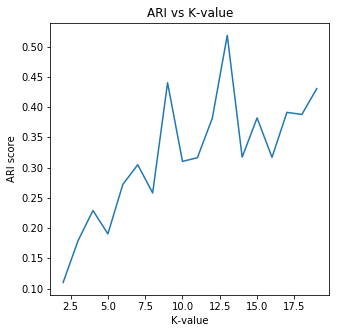

In [71]:
plt.figure(figsize=(5,5))
plt.plot(range(2,20,1),rand)
plt.xlabel('K-value')
plt.ylabel('ARI score')
plt.title('ARI vs K-value')
plt.show()

In [72]:
km = KMeans(n_clusters=15, random_state=42).fit(X_train_bow_norm)
preds = km.predict(X_train_bow_norm)
from sklearn import metrics
labels = km.labels_   
kmean_ari = metrics.adjusted_rand_score(y_train, preds)
print(kmean_ari) 
ari_score.append(kmean_ari)

0.38201496525921963


In [73]:
kmean_sil_score = metrics.silhouette_score(X_train_bow_norm, labels, metric='euclidean')
print(kmean_sil_score)
cluster_scores.iloc[0,1] = kmean_sil_score
silhouette_score.append(kmean_sil_score) 

0.05313824132701334


In [74]:
# add clusters column to matrix
X_train = X_train.copy()
X_train.loc[:,'cluster'] = preds

In [75]:
X_train.groupby('cluster').author.unique()

cluster
0                 [Michael K. Spencer, Carlos E. Perez]
1     [Derrick Harris, Carlos E. Perez, Michael K. S...
2                                         [Conrad Gray]
3                       [Jonathan Hui, Jesus Rodriguez]
4     [Michael K. Spencer, Jonathan Hui, Carlos E. P...
5                                        [Julien Simon]
6                          [Jonathan Hui, Julien Simon]
7                                     [Jesus Rodriguez]
8      [william smith, Sukant Khurana, Carlos E. Perez]
9                          [Julien Simon, Jonathan Hui]
10     [Sukant Khurana, william smith, Carlos E. Perez]
11                                        [Jae Duk Seo]
12                                       [Julien Simon]
13                [Michael K. Spencer, Jesus Rodriguez]
14                   [Jesus Rodriguez, Carlos E. Perez]
Name: author, dtype: object

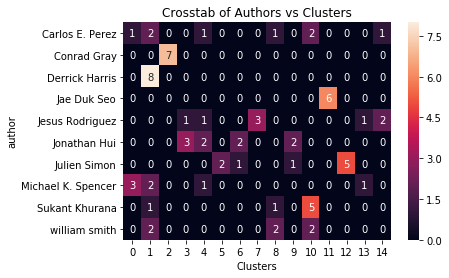

In [76]:
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()

### Kmeans using TF/IDF

In [77]:
rand = []
for k in range(2,20,1):    
    km = KMeans(n_clusters=k, random_state=42).fit(X_train_tfidf_norm)
    preds = km.predict(X_train_tfidf_norm)
    labels = km.labels_
    X = X_train.copy()
    X['clusters'] = preds
    rand.append(metrics.adjusted_rand_score(y_train, preds))
     

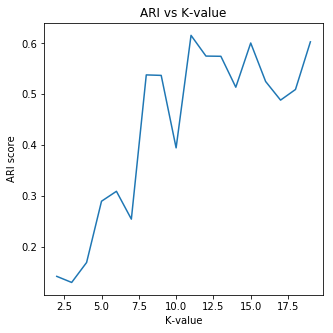

In [78]:
plt.figure(figsize=(5,5))
plt.plot(range(2,20,1),rand)
plt.xlabel('K-value')
plt.ylabel('ARI score')
plt.title('ARI vs K-value')
plt.show()

In [79]:
km = KMeans(n_clusters=11, random_state=42).fit(X_train_tfidf_norm)
preds = km.predict(X_train_tfidf_norm)
from sklearn import metrics
labels = km.labels_   
kmean_ari = metrics.adjusted_rand_score(y_train, preds)
print(kmean_ari)
ari_score.append(kmean_ari)

0.6159199754641753


In [80]:
kmean_sil_score = metrics.silhouette_score(X_train_tfidf_norm, labels, metric='euclidean')
print(kmean_sil_score)
 
silhouette_score.append(kmean_sil_score)
 

0.046306091087399616


In [81]:
X_train = X_train.copy()
X_train.loc[:,'clusters'] = preds

In [82]:
X_train.groupby('clusters').author.unique()

clusters
0                                         [Conrad Gray]
1     [william smith, Sukant Khurana, Jesus Rodrigue...
2                                      [Derrick Harris]
3                    [Jonathan Hui, Michael K. Spencer]
4                                         [Jae Duk Seo]
5                       [Jonathan Hui, Jesus Rodriguez]
6         [Sukant Khurana, Jonathan Hui, william smith]
7                       [Julien Simon, Carlos E. Perez]
8                                     [Jesus Rodriguez]
9                                  [Michael K. Spencer]
10                                    [Carlos E. Perez]
Name: author, dtype: object

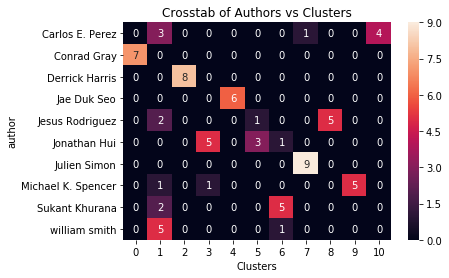

In [83]:
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()

### K-mean LSA

In [84]:
rand = []
for k in range(2,20,1):    
    km = KMeans(n_clusters=k, random_state=42).fit(X_train_lsa)
    preds = km.predict(X_train_lsa)
    labels = km.labels_
    X = X_train.copy()
    X['clusters'] = preds
    rand.append(metrics.adjusted_rand_score(y_train, preds))
     

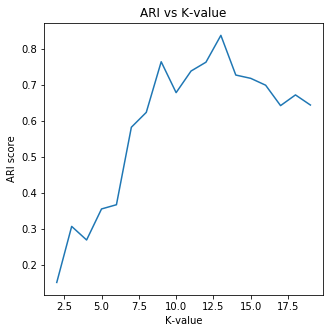

In [85]:
plt.figure(figsize=(5,5))
plt.plot(range(2,20,1),rand)
plt.xlabel('K-value')
plt.ylabel('ARI score')
plt.title('ARI vs K-value')
plt.show()

In [86]:
km = KMeans(n_clusters=9, random_state=42).fit(X_train_lsa)
preds = km.predict(X_train_lsa)
from sklearn import metrics
labels = km.labels_   
kmean_ari = metrics.adjusted_rand_score(y_train, preds)
print(kmean_ari)
ari_score.append(kmean_ari)

0.7638393996914095


In [87]:
kmean_sil_score = metrics.silhouette_score(X_train_lsa, labels, metric='euclidean')
print(kmean_sil_score)
silhouette_score.append(kmean_sil_score)


0.418368615089076


In [88]:
# add clusters column to matrix
X_train = X_train.copy()
X_train.loc[:,'cluster'] = preds

In [89]:
X_train.groupby('cluster').author.unique()

cluster
0                                        [Jae Duk Seo]
1                         [Julien Simon, Jonathan Hui]
2                                        [Conrad Gray]
3                     [Jesus Rodriguez, william smith]
4                                     [Derrick Harris]
5                                     [Sukant Khurana]
6    [william smith, Sukant Khurana, Michael K. Spe...
7                   [Jonathan Hui, Michael K. Spencer]
8                     [Carlos E. Perez, william smith]
Name: author, dtype: object

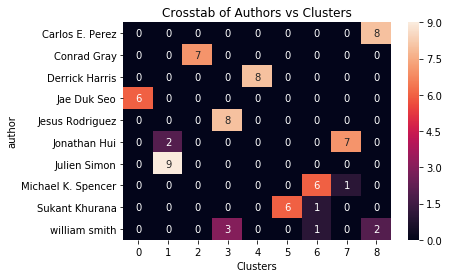

In [90]:
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()

###  Affinity Propogation BOW

In [91]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train_bow_norm)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

 

Done
Estimated number of clusters: 13


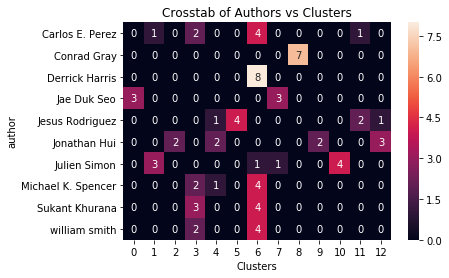

In [92]:
preds = af.predict(X_train_bow_norm)
X_train.loc[:,'clusters'] = preds
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()
plt.show()

In [93]:
from sklearn import metrics
labels = af.labels_
ap_ari = metrics.adjusted_rand_score(y_train, labels)
print(ap_ari)
ari_score.append(ap_ari)

0.2457227072439048


In [94]:
ap_sil = metrics.silhouette_score(X_train_bow_norm, labels, metric='euclidean')
print(ap_sil)
silhouette_score.append(ap_sil)

0.054239747546845296


### Affinity Propogation TF/IDF

In [95]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
 
af = AffinityPropagation().fit(X_train_tfidf_norm)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_
print('Estimated number of clusters: {}'.format(n_clusters_))

 

Done
Estimated number of clusters: 15


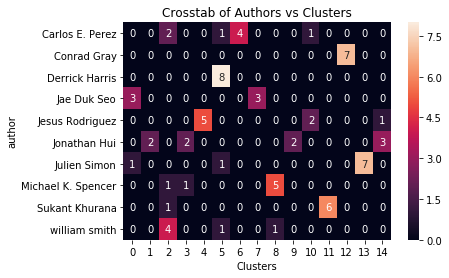

In [96]:
preds = af.predict(X_train_tfidf_norm)
X_train.loc[:,'clusters'] = preds
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()
plt.show()

In [97]:
from sklearn import metrics
labels = af.labels_
ap_ari = metrics.adjusted_rand_score(y_train, labels)
print(ap_ari)
ari_score.append(ap_ari)

0.5565734656528176


In [98]:
ap_sil = metrics.silhouette_score(X_train_tfidf_norm, labels, metric='euclidean')
print(ap_sil)
silhouette_score.append(ap_sil)

0.06175266289925267


### Affinity propogation LSA

In [99]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
 
af = AffinityPropagation(damping=.5).fit(X_train_lsa)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_
print('Estimated number of clusters: {}'.format(n_clusters_))

 

Done
Estimated number of clusters: 14


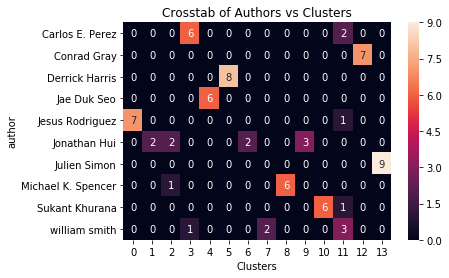

In [100]:
preds = af.predict(X_train_lsa)
X_train.loc[:,'clusters'] = preds
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()
plt.show()

In [101]:
from sklearn import metrics
labels = af.labels_
ap_ari = metrics.adjusted_rand_score(y_train, labels)
print(ap_ari)
ari_score.append(ap_ari)

0.7661237139736682


In [102]:
ap_sil = metrics.silhouette_score(X_train_lsa, labels, metric='euclidean')
print(ap_sil)
silhouette_score.append(ap_sil)

0.515533034518957


### Spectral Clustering BOW

In [103]:
from sklearn.cluster import SpectralClustering
rand = []
for k in range(1,20,1):    
    # We know we're looking for three clusters.
    n_clusters=k

    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters,random_state=42)
    sc.fit(X_train_bow_norm)
    #Predicted clusters.
    predict=sc.fit_predict(X_train_bow_norm)
    rand.append(metrics.adjusted_rand_score(y_train, predict))

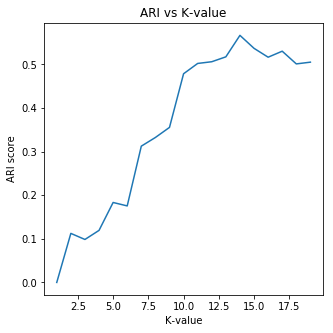

In [104]:
plt.figure(figsize=(5,5))
plt.plot(range(1,20,1),rand)
plt.xlabel('K-value')
plt.ylabel('ARI score')
plt.title('ARI vs K-value')
plt.show()

In [105]:
# Declare and fit the model.
sc = SpectralClustering(n_clusters=14,random_state=42)
sc.fit(X_train_bow_norm)
#Predicted clusters.
predict=sc.fit_predict(X_train_bow_norm) 

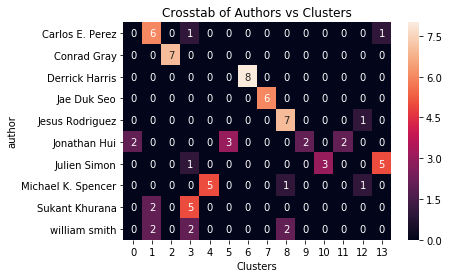

In [106]:
X_train.loc[:,'clusters'] = predict
X_train.groupby('clusters').author.unique()
sns.heatmap(pd.crosstab(y_train,predict),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()
plt.show()

In [107]:
labels = sc.labels_
sc_ari = metrics.adjusted_rand_score(y_train, labels)
print(sc_ari)
ari_score.append(sc_ari)

0.5664422837197707


In [108]:
sc_sil_score = metrics.silhouette_score(X_train_bow_norm, labels, metric='euclidean')
print(sc_sil_score)
silhouette_score.append(sc_sil_score)

0.06937142910945925


### Spectral Clustering TF/IDF


In [109]:
from sklearn.cluster import SpectralClustering
rand = []
for k in range(1,20,1):    
    # We know we're looking for three clusters.
    n_clusters=k

    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters,random_state=42)
    sc.fit(X_train_lsa)
    #Predicted clusters.
    predict=sc.fit_predict(X_train_tfidf_norm)
    rand.append(metrics.adjusted_rand_score(y_train, predict))

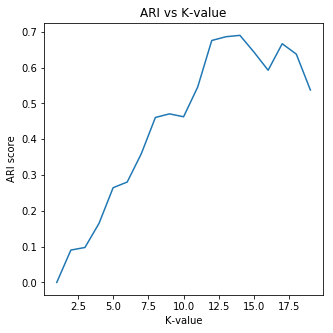

In [110]:
plt.figure(figsize=(5,5))
plt.plot(range(1,20,1),rand)
plt.xlabel('K-value')
plt.ylabel('ARI score')
plt.title('ARI vs K-value')
plt.show()

In [111]:
# Declare and fit the model.
sc = SpectralClustering(n_clusters=13,random_state=42)
sc.fit(X_train_tfidf_norm)
#Predicted clusters.
predict=sc.fit_predict(X_train_tfidf_norm) 

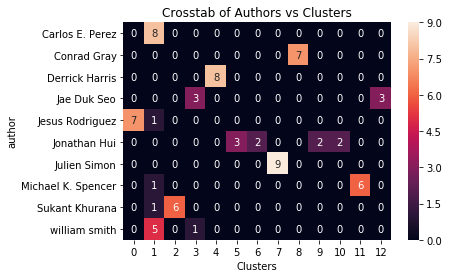

In [112]:
X_train.loc[:,'clusters'] = predict
sns.heatmap(pd.crosstab(y_train,predict),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()
plt.show()

In [113]:
labels = sc.labels_
sc_ari = metrics.adjusted_rand_score(y_train, labels)
print(sc_ari)
ari_score.append(sc_ari)

0.6860192562624136


In [114]:
sc_sil_score = metrics.silhouette_score(X_train_tfidf_norm, labels, metric='euclidean')
print(sc_sil_score)
silhouette_score.append(sc_sil_score)

0.06745488820849495


### Spectoral Clustering LSA

In [115]:
from sklearn.cluster import SpectralClustering
rand = []
for k in range(1,20,1):    
    # We know we're looking for three clusters.
    n_clusters=k

    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters,random_state=42)
    sc.fit(X_train_lsa)
    #Predicted clusters.
    predict=sc.fit_predict(X_train_lsa)
    rand.append(metrics.adjusted_rand_score(y_train, predict))

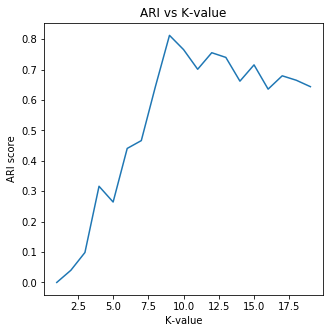

In [116]:
plt.figure(figsize=(5,5))
plt.plot(range(1,20,1),rand)
plt.xlabel('K-value')
plt.ylabel('ARI score')
plt.title('ARI vs K-value')
plt.show()

In [117]:
# Declare and fit the model.
sc = SpectralClustering(n_clusters=10,random_state=42)
sc.fit(X_train_bow_norm)
#Predicted clusters.
predict=sc.fit_predict(X_train_lsa) 

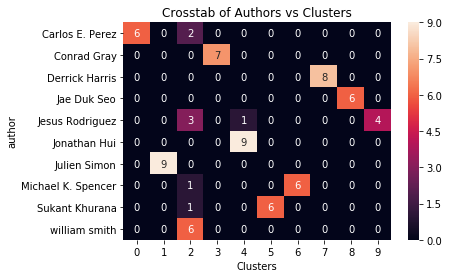

In [118]:
X_train.loc[:,'clusters'] = predict
X_train.groupby('clusters').author.unique()
sns.heatmap(pd.crosstab(y_train,predict),annot=True)
plt.title('Crosstab of Authors vs Clusters')
plt.xlabel('Clusters')
plt.show()
plt.show()

In [119]:
labels = sc.labels_
sc_ari = metrics.adjusted_rand_score(y_train, labels)
print(sc_ari)
ari_score.append(sc_ari)

0.7657378317145458


In [120]:
sc_sil_score = metrics.silhouette_score(X_train_lsa, labels, metric='euclidean')
print(sc_sil_score)
silhouette_score.append(sc_sil_score)

0.42156359695923534


In [121]:
cluster_scores.ARI = ari_score
cluster_scores.Silhouette = silhouette_score


In [122]:
cluster_scores.T

,Kmeans_BOW,Kmeans_TFIDF,Kmeans_LSA,Affinity_BOW,Affinity_TFIDF,Affinity_LSA,Spectral_BOW,Spectral_TFIDF,Spectral_LSA
ARI,0.382015,0.615920,0.763839,0.245723,0.556573,0.766124,0.566442,0.686019,0.765738
Silhouette,0.053138,0.046306,0.418369,0.054240,0.061753,0.515533,0.069371,0.067455,0.421564


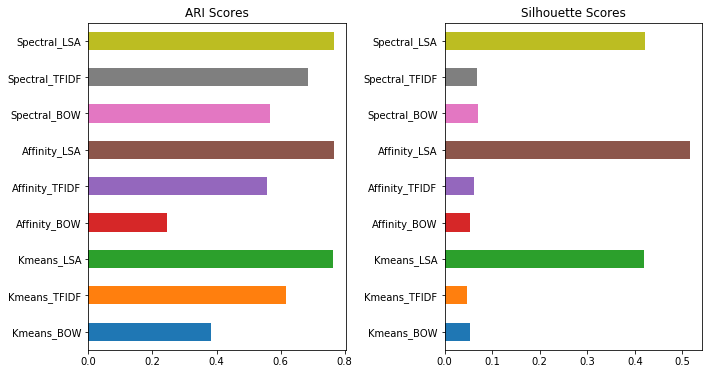

In [123]:
plt.figure(figsize=(10,10),)
plt.subplot(221)
cluster_scores.ARI.plot(kind='barh')
plt.title("ARI Scores")
plt.subplot(222)
cluster_scores.Silhouette.plot(kind='barh')
plt.title("Silhouette Scores")
plt.tight_layout()
plt.show()


Kmeans with LSA comes back with the best ARI score which is the metric we are using because our goal is classification. You can see that all of the algorithms using LSA have much higher silhouette scores than the scores using the other features. Since all of the articles fall under "artificial intelligence" the data is tightly grouped together and it is difficult to cluster. Better cleaning of the data or possibly creating a longer list of domain specific stop words could help raise those scores. However LSA reduces the dimension for us and makes it easier for the algorithms to find better clusters whose members are more closely related and each of those members father from the members in other clusters. Let's return the test set of the data on our best clustering model and see if it is consistent.


## Return Kmeans Test Set

In [124]:
# count of authors in testing set
y_test.value_counts()

william smith         4
Jae Duk Seo           4
Conrad Gray           3
Michael K. Spencer    3
Sukant Khurana        3
Jesus Rodriguez       2
Derrick Harris        2
Carlos E. Perez       2
Jonathan Hui          1
Julien Simon          1
Name: author, dtype: int64

In [125]:
# print trianing set scores for comparison
preds = KMeans(n_clusters=9, random_state=42).fit_predict(X_train_lsa)
# add clusters column to matrix
print('Train set ARI score: ',metrics.adjusted_rand_score(y_train, preds))
print('Train set Silhouette score: ',metrics.silhouette_score(X_train_lsa, preds, metric='euclidean'))
X_train = X_train.copy()
X_train.loc[:,'cluster'] = preds


Train set ARI score:  0.7638393996914095
Train set Silhouette score:  0.418368615089076


In [126]:
# test set  scores
km = KMeans(n_clusters=9, random_state=42).fit(X_test_lsa)
labels = km.labels_   
print('Test set ARI score: ',metrics.adjusted_rand_score(y_test, labels))
print('Test set Silhouette score: ',metrics.silhouette_score(X_test_lsa, labels, metric='euclidean'))

Test set ARI score:  0.8552522746071133
Test set Silhouette score:  0.4391812866771428


In [127]:
# add clusters column to matrix
X_test = X_test.copy()
X_test.loc[:,'cluster'] = labels

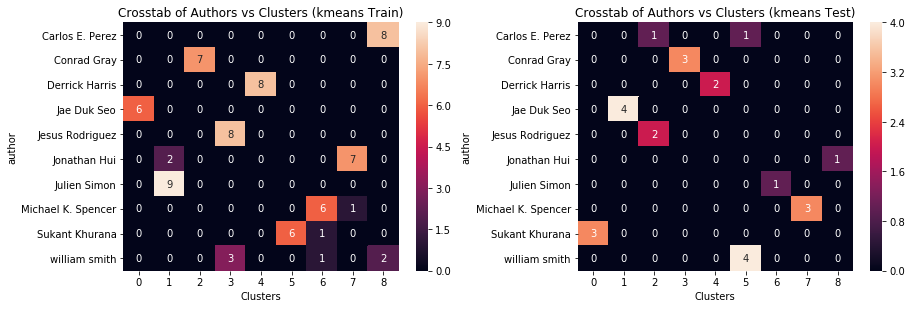

In [128]:
plt.figure(figsize=(13,8))
plt.subplot(221) 
sns.heatmap(pd.crosstab(y_train,preds),annot=True)
plt.title('Crosstab of Authors vs Clusters (kmeans Train)')
plt.xlabel('Clusters')
plt.subplot(222)
sns.heatmap(pd.crosstab(y_test,labels),annot=True)
plt.title('Crosstab of Authors vs Clusters (kmeans Test)')
plt.xlabel('Clusters')
plt.tight_layout()

plt.show()


In [129]:
from sklearn.decomposition import PCA
pca = TruncatedSVD(2)
X_test_pca = pca.fit_transform(X_test_lsa)
plot_X_test = pd.DataFrame(X_test_lsa, index=X_test.author)
plot_X_test['cluster'] = labels
test_LSA_comp1 = X_test_lsa[:,0]
test_LSA_comp2 = X_test_lsa[:,1]



X_train_pca = pca.fit_transform(X_train_lsa)
plot_X_train= pd.DataFrame(X_train_lsa, index=X_train.author)
plot_X_train['cluster'] = preds
train_LSA_comp1 = X_train_lsa[:,0]
train_LSA_comp2 = X_train_lsa[:,1]

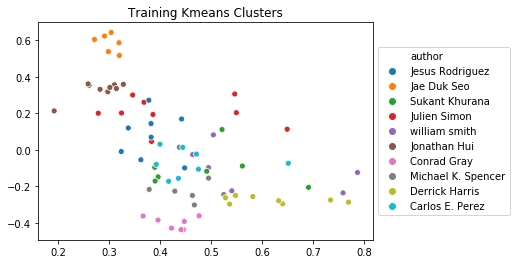

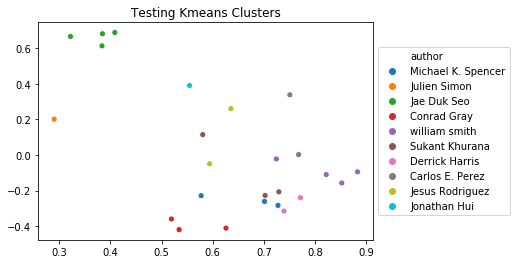

In [130]:
#plt.figure(figsize=(10,5))
sns.scatterplot(train_LSA_comp1,train_LSA_comp2,hue=plot_X_train.index)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Training Kmeans Clusters')


plt.show()
 #plt.figure(figsize=(10,10))

sns.scatterplot(test_LSA_comp1,test_LSA_comp2,hue=plot_X_test.index)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Testing Kmeans Clusters')



# for i, txt in enumerate(plot_X_test.index):
#     plt.annotate(txt, ((test_LSA_comp1[i], test_LSA_comp2[i])))
plt.show()

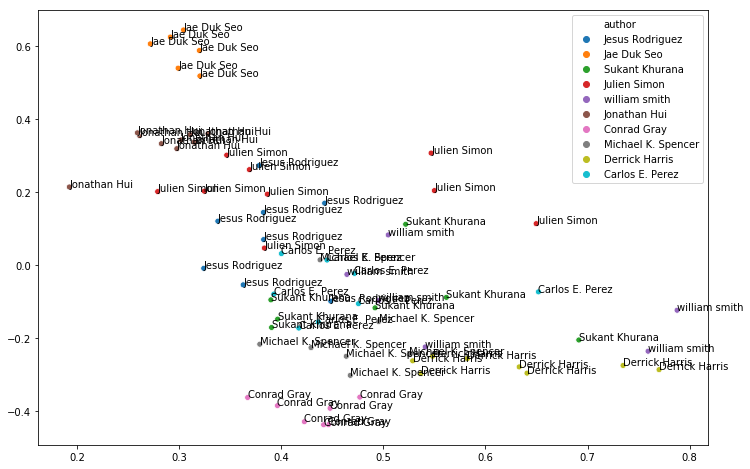

In [131]:
plt.figure(figsize=(12,8))
sns.scatterplot(train_LSA_comp1,train_LSA_comp2,hue=plot_X_train.index)
for i, txt in enumerate(plot_X_train.index):
    plt.annotate(txt, ((train_LSA_comp1[i], train_LSA_comp2[i])))

# Supervised Classification

In [367]:
# empty data frame to hold scores
index=['SVC_BOW','SVC_TFIDF','SVC_LSA',
       'Random_forest_BOW','Random_forest_TFIDF','Random_forest_LSA',
       'Logistic_reg_BOW','Logistic_reg_TFIDF','Logistic_reg_LSA']
Supervised_scores = pd.DataFrame(columns=['Train','Test'],index=index)

# arrays to hold scores
train_score = []
test_score = []

To minimize some of the feature space for TFIDF and BOW features we will use sklearn's SelectPercentile feature selection tool to select the best features within a certain percentile of the original feature set. Our feature space is very large so we will set the percentile to 10%.

In [368]:
# feature selection for TFIDF
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=10)
X_trainTF_selected = selector.fit_transform(X_train_tfidf_norm,y_train).toarray()
X_testTF_selected =  selector.transform(X_test_tfidf_norm).toarray()



 
# feature selection for TFIDF
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=10)
X_train_BOW_selected = selector.fit_transform(X_train_bow_norm,y_train) 
X_test_BOW_selected =  selector.transform(X_test_bow_norm) 
 
 

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [   3    6   13 ... 7564 7565 7568] are constant.
  UserWarning)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [369]:
print(X_trainTF_selected.shape)
print(X_train_BOW_selected.shape)

(75, 652)
(75, 757)


In [370]:
# import the algorithms we will use
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# instatiate the models
clf = LinearSVC(class_weight='balanced')
lr = LogisticRegression(solver='liblinear',multi_class='auto',class_weight='balanced')
rf = RandomForestClassifier(n_estimators=600,max_depth=20,class_weight='balanced')


# generic modeling funtion with metrics
def modeling(model,X_train,X_test,y_train,y_test):
     
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    from sklearn.metrics import classification_report
    print('Classification Report')
    print(classification_report(y_test,pred))
    print(model.score(X_train,y_train))
    print(model.score(X_test,y_test))
    sns.heatmap(pd.crosstab(y_test,pred),annot=True)
    plt.title('Confusion Matrix') 
    plt.show()     
    train_score = model.score(X_train,y_train);
    test_score = model.score(X_test,y_test);
    return train_score, test_score;

## Linear Support Vector Classifer

#### Bag of Words

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       0.50      0.50      0.50         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      1.00      1.00         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.50      1.00      0.67         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       0.75      1.00      0.86         3
     william smith       1.00      0.50      0.67         4

          accuracy                           0.88        25
         macro avg       0.88      0.90      0.87        25
      weighted avg       0.91      0.88      0.88        25

1.0
0.88


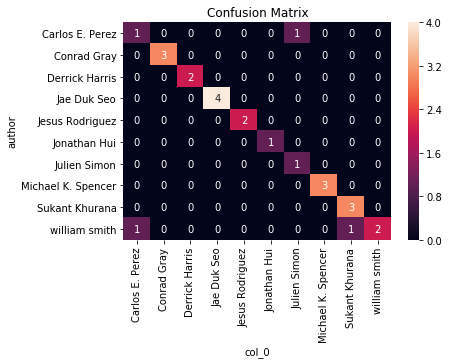

In [371]:
SVC_bow_train_score,SVC_bow_test_score = modeling(clf,X_train_BOW_selected,X_test_BOW_selected,y_train,y_test)
train_score.append(SVC_bow_train_score)
test_score.append(SVC_bow_test_score)

#### TFIDF

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       1.00      1.00      1.00         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      0.50      0.67         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.50      1.00      0.67         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       1.00      1.00      1.00         3
     william smith       1.00      1.00      1.00         4

          accuracy                           0.96        25
         macro avg       0.95      0.95      0.93        25
      weighted avg       0.98      0.96      0.96        25

1.0
0.96


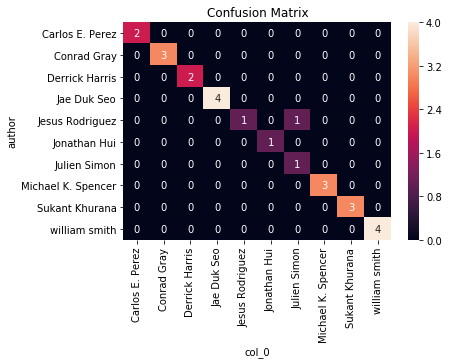

In [372]:
SVC_tfidf_train_score,SVC_tfidf_test_score = modeling(clf,X_trainTF_selected,X_testTF_selected,y_train,y_test)
train_score.append(SVC_tfidf_train_score)
test_score.append(SVC_tfidf_test_score)

#### LSA

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       1.00      1.00      1.00         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      0.50      0.67         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.50      1.00      0.67         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       1.00      1.00      1.00         3
     william smith       1.00      1.00      1.00         4

          accuracy                           0.96        25
         macro avg       0.95      0.95      0.93        25
      weighted avg       0.98      0.96      0.96        25

1.0
0.96


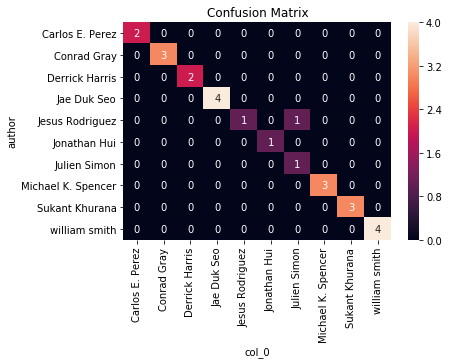

In [373]:
SVC_lsa_train_score,SVC_lsa_test_score = modeling(clf,X_train_lsa,X_test_lsa,y_train,y_test)
train_score.append(SVC_lsa_train_score)
test_score.append(SVC_lsa_test_score)

## Random Forest

#### Bag of words

Classification Report


C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

   Carlos E. Perez       0.50      0.50      0.50         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       0.50      1.00      0.67         2
      Jonathan Hui       0.00      0.00      0.00         1
      Julien Simon       1.00      1.00      1.00         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       1.00      1.00      1.00         3
     william smith       1.00      0.75      0.86         4

          accuracy                           0.88        25
         macro avg       0.80      0.82      0.80        25
      weighted avg       0.88      0.88      0.87        25

1.0
0.88


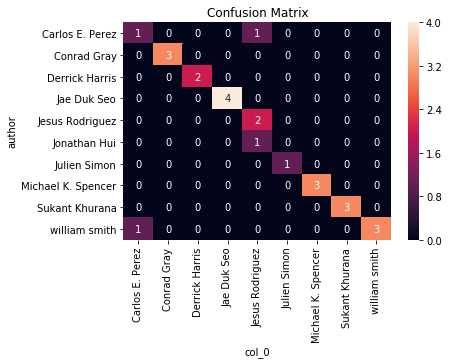

In [374]:
rf_bow_train_score,rf_bow_test_score = modeling(rf,X_train_BOW_selected,X_test_BOW_selected,y_train,y_test)
train_score.append(rf_bow_train_score)
test_score.append(rf_bow_test_score)

#### TFIDF

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       1.00      0.50      0.67         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       0.50      0.50      0.50         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.50      1.00      0.67         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       1.00      1.00      1.00         3
     william smith       1.00      1.00      1.00         4

          accuracy                           0.92        25
         macro avg       0.90      0.90      0.88        25
      weighted avg       0.94      0.92      0.92        25

1.0
0.92


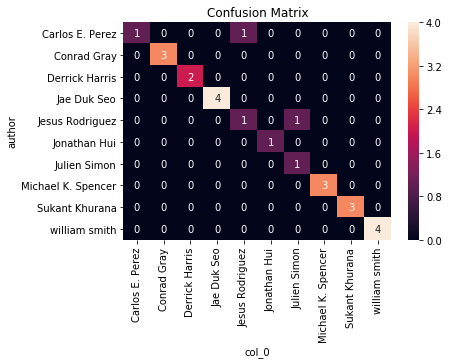

In [375]:
rf_tfidf_train_score,rf_tfidf_test_score = modeling(rf,X_trainTF_selected,X_testTF_selected,y_train,y_test)
train_score.append(rf_tfidf_train_score)
test_score.append(rf_tfidf_test_score)

#### LSA

Classification Report


C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

   Carlos E. Perez       0.00      0.00      0.00         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      0.50      0.67         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.50      1.00      0.67         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       0.75      1.00      0.86         3
     william smith       0.60      0.75      0.67         4

          accuracy                           0.84        25
         macro avg       0.78      0.82      0.79        25
      weighted avg       0.81      0.84      0.81        25

1.0
0.84


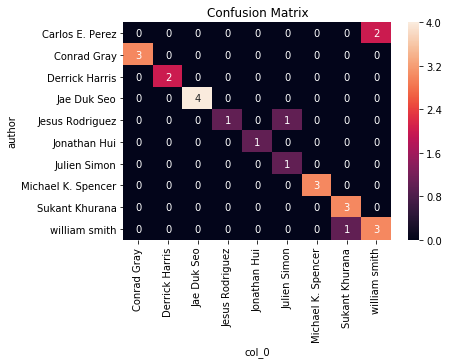

In [376]:
rf_lsa_train_score,rf_lsa_test_score = modeling(rf,X_train_lsa,X_test_lsa,y_train,y_test)
train_score.append(rf_lsa_train_score)
test_score.append(rf_lsa_test_score)

## Logistic Regression

#### Bag of words

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       0.50      0.50      0.50         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      0.50      0.67         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.33      1.00      0.50         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       0.75      1.00      0.86         3
     william smith       1.00      0.50      0.67         4

          accuracy                           0.84        25
         macro avg       0.86      0.85      0.82        25
      weighted avg       0.90      0.84      0.84        25

1.0
0.84


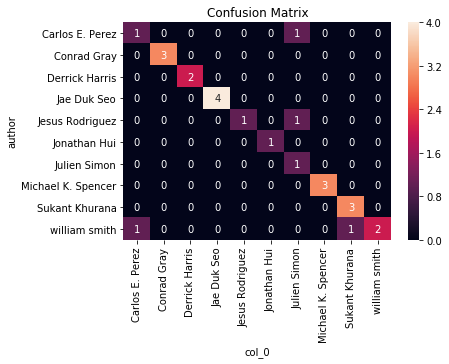

In [377]:
lr_bow_train_score,lr_bow_test_score = modeling(lr,X_train_BOW_selected,X_test_BOW_selected,y_train,y_test)
train_score.append(lr_bow_train_score)
test_score.append(lr_bow_test_score)

#### TFIDF

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       1.00      1.00      1.00         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      0.50      0.67         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.33      1.00      0.50         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       1.00      1.00      1.00         3
     william smith       1.00      0.75      0.86         4

          accuracy                           0.92        25
         macro avg       0.93      0.93      0.90        25
      weighted avg       0.97      0.92      0.93        25

0.9866666666666667
0.92


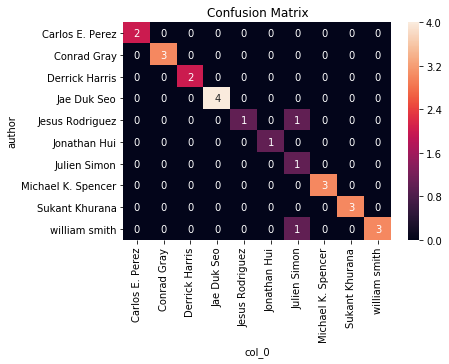

In [378]:
lr_tfidf_train_score,lr_tfidf_test_score = modeling(lr,X_trainTF_selected,X_testTF_selected,y_train,y_test)
train_score.append(lr_tfidf_train_score)
test_score.append(lr_tfidf_test_score)

#### LSA

Classification Report
                    precision    recall  f1-score   support

   Carlos E. Perez       1.00      1.00      1.00         2
       Conrad Gray       1.00      1.00      1.00         3
    Derrick Harris       1.00      1.00      1.00         2
       Jae Duk Seo       1.00      1.00      1.00         4
   Jesus Rodriguez       1.00      0.50      0.67         2
      Jonathan Hui       1.00      1.00      1.00         1
      Julien Simon       0.50      1.00      0.67         1
Michael K. Spencer       1.00      1.00      1.00         3
    Sukant Khurana       1.00      1.00      1.00         3
     william smith       1.00      1.00      1.00         4

          accuracy                           0.96        25
         macro avg       0.95      0.95      0.93        25
      weighted avg       0.98      0.96      0.96        25

0.9866666666666667
0.96


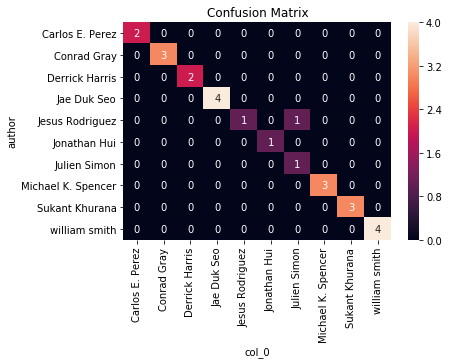

In [379]:
lr_lsa_train_score,lr_lsa_test_score = modeling(lr,X_train_lsa,X_test_lsa,y_train,y_test)
train_score.append(lr_lsa_train_score)
test_score.append(lr_lsa_test_score)

In [381]:
Supervised_scores['Train']=train_score 
Supervised_scores['Test']=test_score 
Supervised_scores

,Train,Test
SVC_BOW,1.000000,0.88
SVC_TFIDF,1.000000,0.96
SVC_LSA,1.000000,0.96
Random_forest_BOW,1.000000,0.88
Random_forest_TFIDF,1.000000,0.92
Random_forest_LSA,1.000000,0.84
Logistic_reg_BOW,1.000000,0.84
Logistic_reg_TFIDF,0.986667,0.92
Logistic_reg_LSA,0.986667,0.96


In [387]:
Supervised_scores

,Train,Test
SVC_BOW,1.000000,0.88
SVC_TFIDF,1.000000,0.96
SVC_LSA,1.000000,0.96
Random_forest_BOW,1.000000,0.88
Random_forest_TFIDF,1.000000,0.92
Random_forest_LSA,1.000000,0.84
Logistic_reg_BOW,1.000000,0.84
Logistic_reg_TFIDF,0.986667,0.92
Logistic_reg_LSA,0.986667,0.96


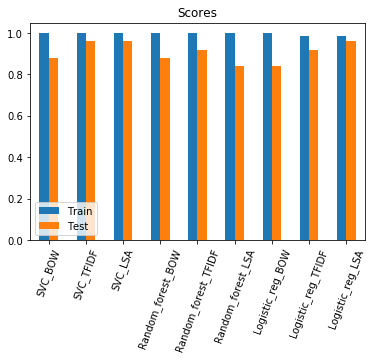

In [385]:
Supervised_scores.plot(kind='bar')
plt.xticks(rotation=70)
plt.title('Scores')
plt.legend(loc='lower left')
plt.show()

## Conclusion

From the results we have seen here it seems that the supervised classification along with some unsupervised feature extraction it a little more accurate at classifying the texts with the correct authors. If you have labeled data and you want to train a model to be able  to accurately classify you the author of a document then supervised classification would be the way to go for this task. Clustering isn’t bad for this task either but it would be better used to see which authors writing styles are the same or if the topics they write about are similar. If you had no labeled data to compare clusters to then you could use clustering for analyzing the topics of the documents and organizing them that way. The supervised learning route doesn't really allow you to analyze the nature of the text itself. Clustering is a little more versatile in looking for patterns but sacrifices accuracy while the supervised models are accurate but perform a very specific task.  
